In [487]:
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [488]:
def imregionalmax(image, kernel=None):
    """Find the regional max of the image. An approximation of MATLAB's
    imregionalmax function. Result only differs when surrounding pixels
    have the same value as the center.

    Parameters:
    - image: the input image
    - kernel: the size of the neiborhood region, default is 3x3, i.e.
              neighboring 8 pixels.
    Returns:
    - a bitmask image, where '1' indicates local maxima.
    Author:
    - Yu Fang
    References:
    - https://github.com/bhardwajvijay/Utils/blob/master/utils.cpp
    - https://stackoverflow.com/questions/5550290/find-local-maxima-in-grayscale-image-using-opencv
    """
    # dialate the image so that small values are replaced by local max
    local_max = cv2.dilate(image, kernel)
    # non-local max pixels (excluding pixel w/ constant 3x3 neighborhood)
    # will be replaced by local max, so the values will increase. remove them.
    # so the result is either local max or constant neighborhood.
    max_mask = image >= local_max
    # erode the image so that high values are replaced by local min
    local_min = cv2.erode(image, kernel)
    # only local min pixels and pixels w/ constant 3x3 neighborhood
    # will stay the same, otherwise pixels will be replaced by the local
    # min and become smaller. We only take non-local min, non-constant values.
    min_mask = image > local_min
    # boolean logic hack
    #   (local max || constant) && (!local min && !constant)
    # = local max && !local min && !constant
    # = local max && !constant
    return (max_mask & min_mask).astype(np.uint8)

In [489]:
def est_homography(src, dest):
    """ Compute the homography matrix from (x_src, y_src) to (x_dest, y_dest).
    Parameters:
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    - dest: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
            so the matrix has dimension Nx2 (N>=4).
    Returns:
    - the homography matrix such that H @ [x_src, y_src, 1].T = [x_dest, y_dest, 1].T
    Author:
    - Yu Fang
    """
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    # take the right singular vector x corresponding to the least singular value
    # s.t. ||Ax - 0||^2 is minimized
    return V.T[:, 8].reshape(3, 3)

In [490]:
def apply_homography(H, src):
    """ Apply the homography H to src
    Parameters:
    - H: the 3x3 homography matrix
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Returns:
    - src: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Author:
    - Yu Fang
    """
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [491]:
def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    """A wrapper around OpenCV's drawMatches.
    
    Parameters:
    - image1: the first image
    - kp1: *matrix indices* of the keypoints from image 1
           (Nx2 numpy array, where N is the number of keypoints)
    - image2: the second image
    - kp2: *matrix indices* of the keypoints from image 2 
           (Nx2 numpy array, where N is the number of keypoints)
    - idx_pairs: pairs of matching indices, e.g. if kp1[3] 
                 matches kp2[5], then idx_pairs=[[3,5],...]
                 (Kx2 numpy array, where K is the number of matches)
    Returns:
    - an image showing matching points
    Author:
    - Yu Fang
    """
    # note that the coordinates are reversed because the difference
    # between matrix indexing & coordinates.
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [492]:
# imregionalmax example (remove this block in the final submission)
A = 10 * np.ones((10, 10))
A[1:4, 1:4] = 22
A[5:8, 5:8] = 33
A[1, 7] = 44
A[2, 8] = 45
A[3, 9] = 44
print(f"A:\n{A}")
print(f"regionmal max:\n{imregionalmax(A)}")

A:
[[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 22. 22. 22. 10. 10. 10. 44. 10. 10.]
 [10. 22. 22. 22. 10. 10. 10. 10. 45. 10.]
 [10. 22. 22. 22. 10. 10. 10. 10. 10. 44.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 33. 33. 33. 10. 10.]
 [10. 10. 10. 10. 10. 33. 33. 33. 10. 10.]
 [10. 10. 10. 10. 10. 33. 33. 33. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]
regionmal max:
[[0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 1 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [493]:
# homography example (remove this block in the final submission)
src = np.array([
    [0, 0],
    [3, 0],
    [0, 2],
    [3, 2]
])
dest = np.array([
    [10, 10],
    [13, 10],
    [12, 12],
    [15, 12]
])

H = est_homography(src, dest)
print(f"H:\n{H}")
dest2 = apply_homography(H, src)
print(f"recover dest:\n{dest2}")

H:
[[-7.00140042e-02 -7.00140042e-02 -7.00140042e-01]
 [ 4.33338378e-15 -7.00140042e-02 -7.00140042e-01]
 [ 4.53873313e-16  8.07299370e-17 -7.00140042e-02]]
recover dest:
[[10. 10.]
 [13. 10.]
 [12. 12.]
 [15. 12.]]


In [494]:
set_number = 1
filepath = f"../images/set{set_number}"
sorted_imagefile = sorted(os.listdir(filepath))
images = [cv2.imread(f"{filepath}/{image}", cv2.IMREAD_GRAYSCALE) for image in sorted_imagefile]

def harris_corner(image):
    
    block, size = 3, 3
    thresh = .01
    k = 0.05

    corner_str = cv2.cornerHarris(image, block, size, k)
    color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    corners = np.argwhere(corner_str> thresh* corner_str.max())
    for y, x in corners:
        cv2.circle(color, (x, y), 3, [255, 0, 0], -1)

    plt.imshow(color, cmap=plt.cm.gray)
    plt.show()
    return corner_str, color

def anms(corner_strengths, num_best):

    y, x = np.where(corner_strengths> .1* corner_strengths.max())
    R = np.full(len(x), np.inf)

    for i in range(len(x)):
        for j in range(len(y)):
            if corner_strengths[y[j], x[j]]> corner_strengths[y[i], x[i]]:
                squared = ((x[j] - x[i]) ** 2)+ ((y[j] - y[i]) ** 2)
                R[i] = min(R[i], squared)
    
    sort_idx = np.argsort(R)[::-1][:num_best]
    x_coord = x[sort_idx]
    y_coord = y[sort_idx]
    return x_coord, y_coord


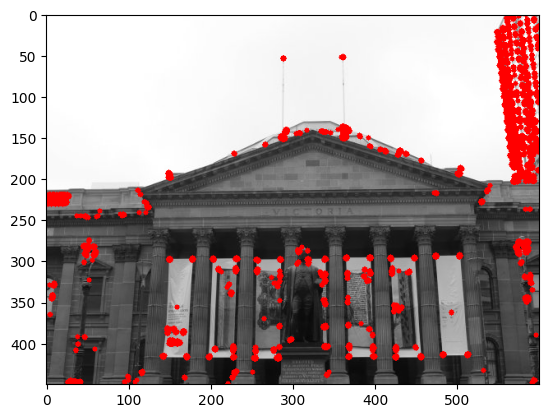

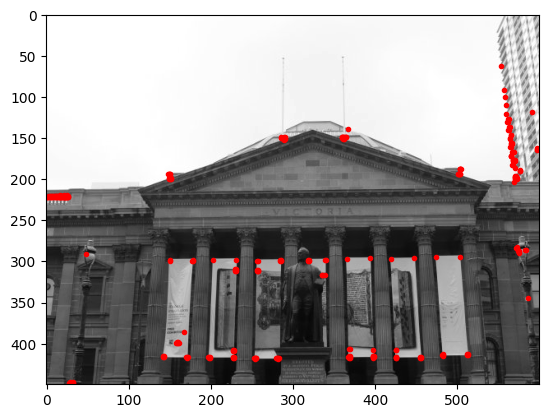

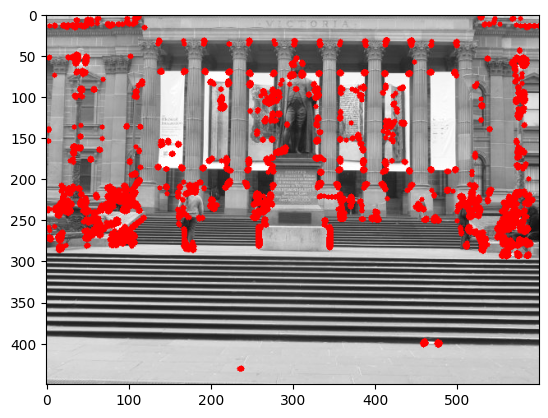

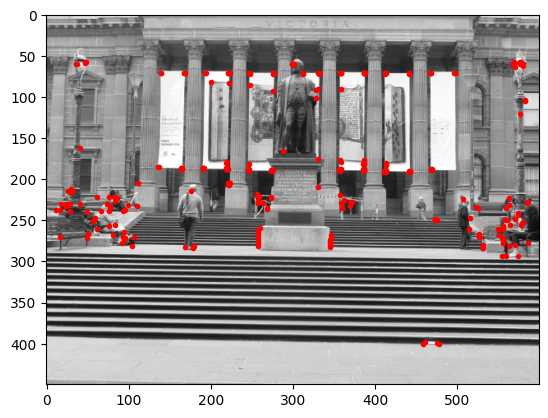

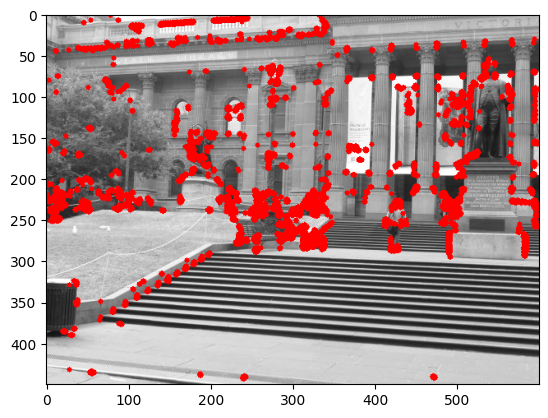

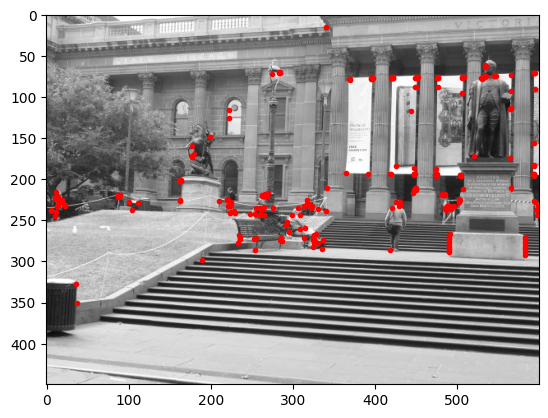

In [495]:
x_coord, y_coord = [], []

for image in images:
    corner_str, color = harris_corner(image)
    x, y = anms(corner_str, 300) 
    x_coord.append(x)
    y_coord.append(y)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.plot(x, y, 'r.')
    plt.show()

In [496]:
def feature_descriptors(image, keypts):
    descriptors = []

    for x_coord, y_coord in zip(*keypts):
        x_start = max(x_coord- 20, 0)
        x_end = min(x_coord+ 20, image.shape[1])
        y_start = max(y_coord- 20, 0)
        y_end = min(y_coord+ 20, image.shape[0])

        area = image[y_start:y_end, x_start:x_end]
        blurred = cv2.GaussianBlur(area, (3, 3), 0)
        resize = cv2.resize(blurred, (8, 8))
        flatten = resize.flatten().reshape(-1, 1)
        mean_val, std_val = np.mean(flatten), np.std(flatten)
        standardized = (flatten-mean_val)/(std_val if std_val> 0 else 1)
        descriptors.append(standardized)
    return descriptors

In [540]:

def feature_matching(image1, image2, corners1, corners2, threshold=0.8):
    if len(image1.shape)==3:
        bw1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    else:
        bw1 = image1

    if len(image2.shape)==3:
        bw2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    else:
        bw2 = image2

    desc1 = feature_descriptors(bw1, corners1)
    desc2 = feature_descriptors(bw2, corners2)
    matched = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    matches = matched.knnMatch(np.array(desc1).astype(np.float32),
                          np.array(desc2).astype(np.float32),
                          k=2)

    filtered_matches = []
    for match, neighbor in matches:
        if match.distance< threshold* neighbor.distance:
            filtered_matches.append(match)
    keypoint1 = [cv.KeyPoint(float(x), float(y), 1) for (x, y) in zip(corners1[0], corners1[1])]
    keypoint2 = [cv.KeyPoint(float(x), float(y), 1) for (x, y) in zip(corners2[0], corners2[1])]
   
    point1, point2 = [], []
    for match in filtered_matches:
        query = match.queryIdx
        idx = match.trainIdx
        kp1, kp2 = keypoint1[query].pt, keypoint2[idx].pt
        point1.append((int(kp1[0]), int(kp1[1])))
        point2.append((int(kp2[0]), int(kp2[1])))

    img_matches = cv.drawMatches(image1, keypoint1, image2, keypoint2, filtered_matches, None,
                                  flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
                                  matchColor=(255, 255, 0))
    plt.imshow(img_matches)
    plt.show()
    return point1, point2

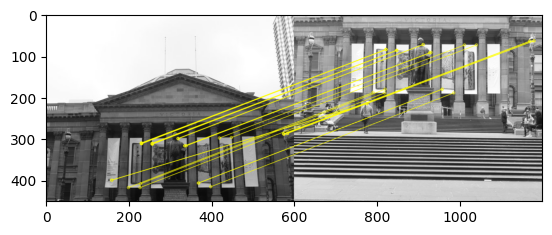

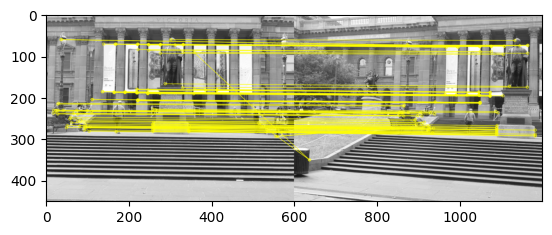

In [541]:
kp1, kp2 = [],[]

for i in range(1,len(images)):
    image1, image2 = images[i-1], images[i]
    image1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)    
    image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)
    temp1, temp2 = feature_matching(image1, image2, (x_coord[i-1], y_coord[i-1]), (x_coord[i], y_coord[i]))
    kp1.append(temp1)
    kp2.append(temp2)


In [563]:
def ransac(matches, leftcoords, rightcoords, n):
    best_inliers = []

    for iter in range(n):
        indices = np.random.choice(matches.shape[0], size=4)
        coords = matches[indices]
        src = leftcoords[coords[:, 0]]
        dest = rightcoords[coords[:,1]]
        homography_mat = est_homography(src, dest)
        new_dest = apply_homography(homography_mat, np.array([leftcoords[i[0]] for i in matches]))
        new_dest2 = [rightcoords[i[1]] for i in matches]
        squared_differences = np.sum((new_dest - new_dest2)**2,axis=-1)
        inliers = []
        for i, sqdiff in enumerate(squared_differences):
            if sqdiff < 10:
                inliers.append(matches[i])
        best_inliers = best_inliers if len(best_inliers) >= len(inliers) else inliers
    return np.array(best_inliers)

In [565]:

matches = []
for i in range(len(kp1)):
    matches.append(np.array([(i, i) for i in range(len(kp1[i]))]))
    matches[i] = ransac(matches[i], kp1[i], kp2[i], 1000)

for i in range(len(kp1)):
    image1, image2 = images[i], images[i+1]
    image1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)
    drawMatches(image1, np.array(kp1[i]), image2, np.array(kp2[i]), matches[i])
    plt.show()




    



TypeError: only integer scalar arrays can be converted to a scalar index

In [556]:
def blending(source_image, target_image, transform_matrix):
    # Extract dimensions of both images
    source_height, source_width = source_img.shape[:2]
    target_height, target_width = target_image.shape[:2]

    source = np.float32([[0,0], [source_width, 0],[source_width, source_height], [0, source_height]]).reshape(-1, 1, 2)
    target = cv2.perspectiveTransform(np.float32([[0,0],[target_width, 0], [target_width, target_height], [0, target_height]]).reshape(-1, 1, 2),transform_matrix)

    all_corners = np.vstack((source, target))
    corner_min = np.int32(all_corners.min(axis=0).ravel())
    corner_max = np.int32(all_corners.max(axis=0).ravel())

    offset = [-corner_min[0], -corner_min[1]]
    offset_transformation = np.array([[1, 0, offset[0]],[0,1,offset[1]], [0, 0, 1]])
    transformed = cv2.warpPerspective(target_image, offset_transformation.dot(transform_matrix), (corner_max[0]- corner_min[0], corner_max[1]- corner_min[1]))
    result = transformed.copy()

    for y in range(source_height):
        for x in range(source_width):
            transformed_x, transformed_y = x+ offset[0], y+ offset[1]
            if np.all(result[transformed_y, transformed_x]==0):
                result[transformed_y, transformed_x]= source_img[y, x]
            else:
                source_pixel = source_img[y,x]
                target_pixel = result[transformed_y, transformed_x]
                result[transformed_y,transformed_x] = (source_pixel/2+target_pixel/2).astype(np.uint8)
    return result, offset

In [562]:
#print results

    